# Categorical variables: optimizing a neural network with TensorFlow and Emukit

This notebook is going to illustrate how to use categorical variables with Emukit.

In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Necessary imports
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import GPy

from emukit.core import ContinuousParameter, ParameterSpace, CategoricalParameter, OneHotEncoding
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

For this example we are going to optimize a very simple neural network built with TensorFlow. We will reuse the very first example of [how to use TensorFlow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/_index.ipynb) with number of epochs reduced to 1 in the interest of saving time. We are going to consider two hyper parameters that are going to be subjects of optimization:
* Type of optimizer. We are going to choose from Adam, AdaGrad and SGD. This is clearly a categorical parameter.
* Dropout rate, ranging between 0.05 and 0.95. This parameter is continuous.  

Here is the definition of the function we are going to optimize:

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 

def eval_model(dropout_rate, optimizer):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(dropout_rate),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=1)
    loss, accuracy = model.evaluate(x_test, y_test)
    
    return accuracy

Emukit takes both objective and model as inputs. So when users come to Emukit it is expected that they have already done necessary conversions to turn categorical parameters into numerical values, known as encodings.

Encodings in Emukit are represented with `Encoding` class and its subclasses. Emukit provides implementations for a few standard encodings (at the time of writing there are two: one hot and ordinal). If your encoding is not included in one of these, you can either `Encoding` class directly, or subclass it. We should leave discussion of these options to a different tutorial.

For this example we will use one hot encoding already included in Emukit.

In [4]:
optimizers = ['adam', 'adagrad', 'sgd']
encoding = OneHotEncoding(optimizers)
space = ParameterSpace([
    ContinuousParameter('dropout_rate', 0.05, 0.95),
    CategoricalParameter('optimizer', encoding)
])

Emukit requires objective function to accept 2d array as an input, and it also expects model and objective function to accept input of the same form. It is not the case with our objective yet: it declares input parameters explicitly, and expects optimizer name instead of encoding value. Let's fix it. Note how we can use our encoding object here:

In [5]:
def emukit_friendly_objective_function(input_rows):
    output = []
    for row in input_rows:
        dropout_rate = row[0]
        optimizer = encoding.get_category(row[1:])
        eval_result = eval_model(dropout_rate, optimizer)
        
        # Emukit minimizes, so we need to revert accuracy
        output.append([-1 * eval_result])
    
    return np.array(output)

We can use random forest as our model, which comes in Emukit's examples package. Notice that you need Scikit-learn installed to be able to use it. We will use a couple of random values to initialize it:

In [6]:
from emukit.examples.models.random_forest import RandomForest
from emukit.experimental_design import RandomDesign

random_design = RandomDesign(space)
initial_points_count = 5
X_init = random_design.get_samples(initial_points_count)
Y_init = emukit_friendly_objective_function(X_init)

rf_model = RandomForest(X_init, Y_init)

10000/10000 [==============================] - 0s 45us/sample - loss: 0.1492 - acc: 0.9561


Let's examine the returned data:

In [7]:
Y_init

array([[-0.94690001],
       [-0.96130002],
       [-0.89910001],
       [-0.96859998],
       [-0.95609999]])

At this point everything is ready to run the optimization loop.

In [8]:
from emukit.core.optimization import LocalSearchAcquisitionOptimizer

ls = LocalSearchAcquisitionOptimizer(space, num_steps=10, num_init_points=5)
loop = BayesianOptimizationLoop(model=rf_model, space=space, acquisition_optimizer=ls)
loop.run_loop(emukit_friendly_objective_function, 10)

10000/10000 [==============================] - 1s 54us/sample - loss: 0.1113 - acc: 0.9652


Let's plot the results of the optimization run.

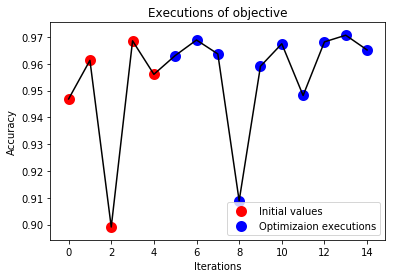

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

accuracies = -1 * loop.loop_state.Y

plt.title('Executions of objective')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(range(accuracies.shape[0]), accuracies[:, 0], c='k')
plt.scatter(range(initial_points_count), accuracies[:initial_points_count, 0], c='r', linewidths=5, label="Initial values")
plt.scatter(range(initial_points_count, accuracies.shape[0]), accuracies[initial_points_count:, 0], c='b', linewidths=5, label="Optimizaion executions")
plt.legend();